In [3]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)

import scipy.integrate as integrate

In [4]:
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import numpy as np
import time

nb.__version__


'0.55.2'

### Generate sample paths from the SDE
$$ dX = - V'(x) dt + \sqrt{2 \tau} dW $$

where $$ V'(x) = -\frac{1}{x^3}+2x $$

Below is a numba code that compute sample path for the SDE stated above using the Euler-Maruyama numerical scheme.

In this notebook, I focus on evaluating the error on the distribution of the simulated samples path when compared to a "true" distribution. As it is impossible to know the true distribution at each time, one needs to reflect on the definition of error. 

When using a numerical scheme such as Euler-Maruyama, an approximation has been made and some terms have been neglected in the Ito Taylor expansion used to obtain this result. The simulated results have therefore a bias compared to the true solution. Using numerical simulation also means that a numerical error is introduced in the results. Both type of error are important. While the bias is difficult to assess as we do not have exact solution at each time, it is possible to evaluate the numerical error introduced by a scheme by comparing to a true solution. 

Evaluate the error numerically involves establishing a definition for it. From Leimkuhler, Matthews and Tretyakov, the true distribution is: $\rho(t,x)$, it evolves from the initial value $\rho(0,x)$ to $\rho(\infty,x)=\rho_{\infty}$. Let's define an observable $\phi$, then the average of $\phi$ at time $t$ is : 
$$
\bar{\phi}(t)=E_{\rho(t,.)} \phi = \int_{\mathcal{R}^d} \phi(x) \rho(t,x) dx
$$

The discretisation scheme can be seen to give rise to an evolving probability distribution $\rho_i$. If stepsize $h$ is used, then the average at time $t=N h$ is given by: 
$$
\hat{\phi}(t,h)=E_{\rho_N(.)} \phi = \int_{\mathcal{R}^d} \phi(x) \rho_N(x)dx
$$

To quantify the error, one can compare $\hat{\phi}$ and $\phi$, such as: 
$$
|\hat{\phi}(t)-\bar{\phi}(t,h)|\leqslant C(h) h
$$

However, in the first place, I will compute different values of $\hat{\phi}(\tau,h)$, varying not only the time discretisation $h$, but also the temperature in the sde $\tau$ and the final time $T_f$. 

The observable function I choose in this case is $\phi(x)=\eta(x,\tau)$:
$$\eta(x|\tau)=\begin{equation*}
\left\{ 
  \begin{aligned}
    &1\,   &\text{if }\,  0 \geqslant x\geqslant b \\
    &0\,   &\text{else } \\
  \end{aligned}
  \right.
\end{equation*}
$$
such that: 
$$
\bar{\eta}(t|\tau)=E_{\rho(t,.)} \eta = \int_{b}^\infty \rho(t,x) dx= \mathbb{P}_{\rho(t,.)}(X\geqslant b)
$$

and 
$$
\hat{\eta}(t|\tau)=E_{\rho_N(.)} \eta =\int_{b}^\infty \rho_N(x) dx= \mathbb{P}_{\rho_N(.)}(X\geqslant b).
$$

In addition to depending on the time discretisation $h$ and the time $t$, the observable also depends on the temperature of the SDE of interest $\tau$. In order to make the dependancy obvious, I define the error of the numerical simulation as: 

$$
\hat{\eta}(t,\tau, h) = E_{\rho_N(.,.)} \eta =\int_{b}^\infty \rho_N(x,\tau, h) dx= \mathbb{P}_{\rho_N(.)}(X\geqslant b).
$$

An other option for the observable function is to count any paths which at any points have unrealistic behaviour. Such a measure is not an observable but rather: 
$$
P(\exists ! x: x < 0 | x > b \ \ \forall t \in [0,T])
$$

In order to compute this probability, it suffices to exclude any numerical path that exceeds those treshold values at any point during the simulation. 
  

Below, I will try to see how the observable average $\eta$ and see how it evolves using changes in the three parameters. Additionally, I will also look at computing this probability and see how it evolves when varying those function. 

### Measure the average of the observable   
In this section, we aim at measuring: 
$$
\hat{\eta}(t|\tau)=E_{\rho_N(.)} \eta =\int_{b}^\infty \rho_N(x) dx= \mathbb{P}_{\rho_N(.)}(X\geqslant b).
$$

We have samples path $X_i^{(j)}$, with $i =1...N_{tot}$ computed as $N_{tot}=\frac{T_f}{\Delta t}$. The index $i$ is the index of the time discretisation while the index $j$ is the index of the number of sample produced at time $T_f$. We have that $j=1,...n_{sample}$.
$$
\mathbb{P}_{\rho_{N_{tot}}(.)}(0 \geqslant X\geqslant b)  \approx \frac{\sum \{ X_{N_{tot}}^{(j)} | X_{N_{tot}}^{(j)} >b \text{ or }X_{N_{tot}}^{(j)} <0 \}}{ \sum_j^{n_{\text{sample}}}  X_{N_{tot}}^{(j)} }
$$
In word, we assess a time $T_f$ the proportion of path that are outside the bound. This is the easiest to implement. 

In [24]:
## numba code

%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_nsample.py"

<Figure size 432x288 with 0 Axes>

Firslty, we test the code to ensure that the results produced by the numba code are consistent. Let's compare for long time the invariant distribution to the distribution of the samples produced. This is for small value of dt. 

In [5]:
## Plot results on the simulation
n_samples = 10**4
dt=0.01
b1=0.1
b2=1.5
inc=(b2-b1)/5
tau_list=np.round(np.arange(b1,b2+inc,inc),3)
T=100
# empty vector to save results
y_res1 = np.zeros((len(tau_list),n_samples))

#run through the different values of tau 
for i in range(len(tau_list)):
    tau_i=tau_list[i]
    y_exact =IDW_nsample(n_samples,T,dt,tau_i)
    y_res1[i,::]=y_exact

In [9]:
## Plot results on the simulation
dt=0.1
T=100
# empty vector to save results
y_res2 = np.zeros((len(tau_list),n_samples))

#run through the different values of tau 
for i in range(len(tau_list)):
    tau_i=tau_list[i]
    y_exact =IDW_nsample(n_samples,T,dt,tau_i)
    y_res2[i,::]=y_exact

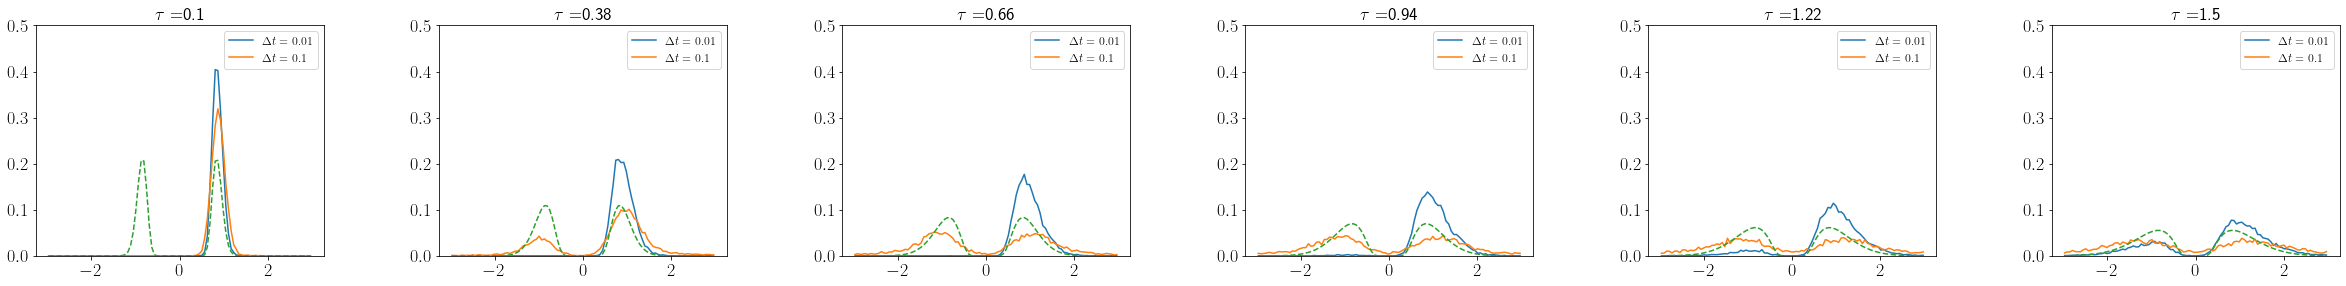

In [10]:
# axis of the plot 
fig, (axs)= plt.subplots(1, len(tau_list),figsize=(40,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



## Plot 1 
for i in range(len(tau_list)):
    ye2 = y_res2[i,::] #exctract the result of interest from the list
    ye1 = y_res1[i,::] #exctract the result of interest from the list
    tau_i = tau_list[i] #exctract the value of tau of interest from the list 


    # value of the indexes for the plot and bounds for histograms
    bounds=[-3,3]
    # j=0
    # if i>4:
    #     j=1
    #     i= i-5
    #     bounds=[-10,10]

    # add histograms with value of dt=0.1
    histogram1,bins1 = np.histogram(ye1,bins=100,range=bounds, density=True)
    midx1 = (bins1[0:-1]+bins1[1:])/2
    histogram1=(histogram1/np.sum(histogram1))*2
    axs[i].plot(midx1,histogram1,label='$\\Delta t =0.01$')

    # add histograms with value of dt=0.1
    histogram2,bins2 = np.histogram(ye2,bins=100,range=bounds, density=True)
    midx2 = (bins2[0:-1]+bins2[1:])/2
    histogram2=(histogram2/np.sum(histogram2))*2
    axs[i].plot(midx1,histogram2,label='$\\Delta t =0.1$')

    # Plot the value of the histogram
    axs[i].set_title('$\\tau =$'+str(tau_i))
    axs[i].legend() #add the legend
    axs[i].set_ylim(0,0.5) 
    midx = (bins1[0:-1]+bins1[1:])/2
    rho = np.exp(- (U(midx)/tau_i))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    axs[i].plot(midx,rho,'--',label='Truth')   

The plots looks right, let's compute the escaping trajectories with different values of the temperature $\tau$. 

In [25]:
def nesc_eta_taulist(n_samples,dt,list_var,T,b):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    n_samples: int
        number of samples generated
    dt: float
        Time increment
    list_var: list of float
        list of values of the temperature to evaluate 
    T: int
        Final time until the solution is ran
    b: int
        Boundary selected
    """
    # empty vector to save results
    y_res = np.zeros((len(list_var),n_samples))
    #list of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(list_var)):
        tau_i=list_var[i]
        y_exact = IDW_nsample(n_samples,T,dt,tau_i)
        y_res[i,::]=y_exact

        #compute the proportion of escaping trajectory
        res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)
        
    return(nesc_list,y_res)

In [26]:
## Plot results on the simulation
n_samples = 10**5
dt=0.01
b1=0.1
b2=3
inc=(b2-b1)/30
tau_list1=np.round(np.arange(b1,b2+inc,inc),3)
T=100
b=50
nesc1, y_res1 = nesc_eta_taulist(n_samples,dt,tau_list1,T,b)

In [27]:
## Plot results on the simulation
n_samples = 10**5
dt=0.1
b1=0.1
b2=3
inc=(b2-b1)/30
tau_list2=np.round(np.arange(b1,b2+inc,inc),3)
T=100
nesc2, y_res2 = nesc_eta_taulist(n_samples,dt,tau_list2,T,b)

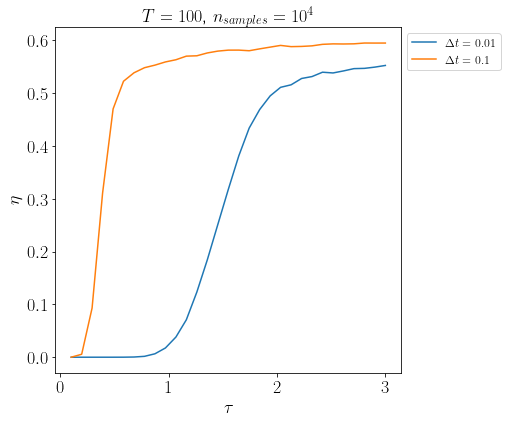

In [29]:
fig, (ax1)= plt.subplots(1, 1,figsize=(6,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

ax1.plot(tau_list1,nesc1,label="$\Delta t=0.01$")
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax1.set_ylabel("$\\eta$")
ax1.set_xlabel("$\\tau $")
ax1.set_title("$T=100$, $n_{samples}=10^4$")
ax1.plot(tau_list2,nesc2,label="$\Delta t=0.1$")
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend


For $\Delta t=0.01$, it seems more interesting to look at what happens between $\tau=0.7$ and $\tau=2.3$. 

For $\Delta t=0.1$, it is interesting to look at $\tau=0.01$ and $\tau=1$.

In [30]:
## Plot results on the simulation
n_samples = 10**5
dt=0.01
b1=0.7
b2=2.3
inc=(b2-b1)/30
tau_list7=np.round(np.arange(b1,b2+inc,inc),3)
T=100
nesc7, y_res7 = nesc_eta_taulist(n_samples,dt,tau_list7,T,b)

In [31]:
## Plot results on the simulation
n_samples = 10**5
dt=0.1
b1=0.01
b2=1
inc=(b2-b1)/30
tau_list8=np.round(np.arange(b1,b2+inc,inc),3)
T=100
nesc8, y_res8 = nesc_eta_taulist(n_samples,dt,tau_list8,T,b)

Text(0.5, 1.0, '$T=100$, $n_{samples}=10^5$')

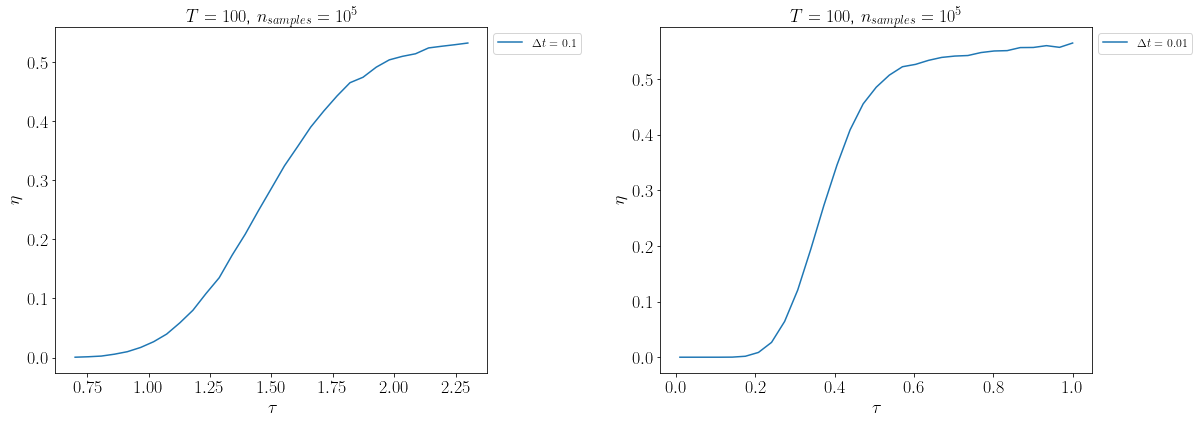

In [32]:
fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(18,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

ax1.plot(tau_list7,nesc7,label="$\Delta t=0.1$")
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax1.set_ylabel("$\\eta$")
ax1.set_xlabel("$\\tau $")
ax1.set_title("$T=100$, $n_{samples}=10^5$")

ax2.plot(tau_list8,nesc8,label="$\Delta t=0.01$")
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax2.set_ylabel("$\\eta$")
ax2.set_xlabel("$\\tau $")
ax2.set_title("$T=100$, $n_{samples}=10^5$")

Let's look at different values of the time increment $\Delta t$.  

Let's start by looking at very high values of dt, where we know it will diverge, as it will facilitate the simulations as it takes less time.


In [7]:
def nesc_eta_dtlist(n_samples,dt_var,tau,T,b):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    n_samples: int
        number of samples generated
    dt: float
        Time increment
    list_var: list of float
        list of values of the temperature to evaluate 
    T: int
        Final time until the solution is ran
    b: int
        Boundary selected
    """
    # empty vector to save results
    y_res = np.zeros((len(dt_var),n_samples))
    #list of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(dt_var)):
        dt_i=dt_var[i]
        y_exact = IDW_nsample(n_samples,T,dt_i,tau)
        y_res[i,::]=y_exact

        #compute the proportion of escaping trajectory
        res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)
        
    return(nesc_list,y_res)

In [21]:
n_samples=10**5
tau=0.01
b1=0.05
b2=0.4
inc=(b2-b1)/10
dtlist3=np.arange(b1,b2+inc,inc)
T=100
b=10
nesc3, y_res3 = nesc_eta_dtlist(n_samples,dtlist3,tau,T,b)

In [11]:
n_samples=10**5
tau=0.15
b1=0.05
b2=0.4
inc=(b2-b1)/10
dtlist4=np.arange(b1,b2+inc,inc)
T=100
b=10
nesc4, y_res4 = nesc_eta_dtlist(n_samples,dtlist4,tau,T,b)


In [19]:
n_samples=10**5
tau=0.3
b1=0.05
b2=0.4
inc=(b2-b1)/10
dtlist5=np.arange(b1,b2+inc,inc)
T=100
b=10
nesc5, y_res5 = nesc_eta_dtlist(n_samples,dtlist5,tau,T,b)

In [20]:
n_samples=10**5
tau=0.07
b1=0.05
b2=0.4
inc=(b2-b1)/10
dtlist6=np.arange(b1,b2+inc,inc)
T=100
b=10
nesc6, y_res6 = nesc_eta_dtlist(n_samples,dtlist6,tau,T,b)

Text(0.5, 1.0, '$T=100$, $n_{samples}=10^5$')

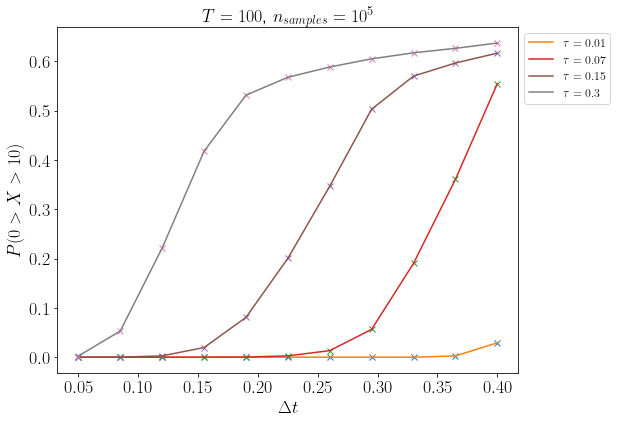

In [22]:
fig, (ax)= plt.subplots(1, 1,figsize=(8,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

ax.plot(dtlist3,nesc3,"x")
ax.plot(dtlist3,nesc3,label="$\\tau=0.01$")
ax.plot(dtlist6,nesc6,"x")
ax.plot(dtlist6,nesc6,label="$\\tau=0.07$")
ax.plot(dtlist4,nesc4,"x")
ax.plot(dtlist4,nesc4,label="$\\tau=0.15$")
ax.plot(dtlist5,nesc5,"x")
ax.plot(dtlist5,nesc5,label="$\\tau=0.3$")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax.set_ylabel("$P(0 > X> 10) $")
ax.set_xlabel("$\Delta t $")
ax.set_title("$T=100$, $n_{samples}=10^5$")
